<a href="https://colab.research.google.com/github/rallm/IUST-DL-Fall2025/blob/main/HW2/Practical/adversarial_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Adversarial Attacks

## Part 1 – Training a Convolutional Neural Network on the SVHN Dataset



We will train a classifier on the SVHN (Street View House Numbers) dataset, which can be accessed via torchvision.datasets. The model is expected to achieve at least 90% accuracy on the test set.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F


In [7]:
import torchvision
import torchvision.transforms as transforms
import torch.utils.data

# Define Training Data Augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    # Hint: Add a common augmentation technique that flips images horizontally at random.
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    # Hint: Normalize the tensor images. A common practice is to use a mean and standard deviation of 0.5 for each of the three channels.
    # This transform expects two tuples: (mean_R, mean_G, mean_B) and (std_R, std_G, std_B).
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define Test Data Augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load SVHN Dataset
trainset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform_train)

# Hint: Create a data loader for the training set. Use a batch size of 128 and make sure to shuffle the data.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 182M/182M [00:12<00:00, 14.7MB/s] 
100%|██████████| 64.3M/64.3M [00:04<00:00, 13.1MB/s]


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# Check for GPU availability and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
# Updated Data Augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    # Hint: Set the maximum degrees for the random rotation. A value like 15 is a good start.
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Updated Model Architecture
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 2 * 2)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Updated Training Function with Learning Rate Scheduler
def train_model_with_scheduler(model, trainloader, criterion, optimizer, scheduler, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Hint: Implement the standard training steps in order:
            # zero gradients, forward pass, calculate loss, backward pass, and update weights.
            # Then, add the batch loss to the 'running_loss'.
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Hint: After the optimizer step, update the scheduler as well.
        scheduler.step() # I change indent of this

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(trainloader):.4f}")

In [10]:
# Main Execution
model = ImprovedCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
# Hint: Use a scheduler that multiplies the learning rate by a 'gamma' factor every 'step_size' epochs.
# For example, reduce the LR by a factor of 0.1 every 10 epochs.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train_model_with_scheduler(model, trainloader, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20, Loss: 1.7541
Epoch 2/20, Loss: 0.9485
Epoch 3/20, Loss: 0.7346
Epoch 4/20, Loss: 0.6367
Epoch 5/20, Loss: 0.5762
Epoch 6/20, Loss: 0.5356
Epoch 7/20, Loss: 0.5048
Epoch 8/20, Loss: 0.4813
Epoch 9/20, Loss: 0.4559
Epoch 10/20, Loss: 0.4419
Epoch 11/20, Loss: 0.3734
Epoch 12/20, Loss: 0.3505
Epoch 13/20, Loss: 0.3440
Epoch 14/20, Loss: 0.3395
Epoch 15/20, Loss: 0.3317
Epoch 16/20, Loss: 0.3301
Epoch 17/20, Loss: 0.3285
Epoch 18/20, Loss: 0.3217
Epoch 19/20, Loss: 0.3203
Epoch 20/20, Loss: 0.3170


In [11]:
def evaluate_model(model, testloader):
    model.eval()
    all_preds = []
    all_labels = []
    incorrect_samples = []
    incorrect_true_labels = []
    incorrect_pred_labels = []
    correct = 0
    total = 0

    # Hint: Use a torch context manager to disable gradient calculations for efficiency.
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Hint: From the raw 'outputs', find the index of the maximum value along dimension 1 to get the predicted labels.
            _, preds = torch.max(outputs.data, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Calculate total and correct predictions
            total += labels.size(0)

            # Hint: Count how many predictions match the true labels in this batch and add the number to the 'correct' variable.
            correct += (preds == labels).sum().item()

            # Collect incorrect predictions
            # Hint: Create a boolean mask to identify which predictions were incorrect.
            mismatches = (preds != labels)

            # Hint: Use the 'mismatches' mask to select and store the input images that were misclassified.
            incorrect_samples.extend(inputs[mismatches])
            incorrect_true_labels.extend(labels[mismatches].cpu().numpy())
            incorrect_pred_labels.extend(preds[mismatches].cpu().numpy())

    # Calculate and print accuracy
    accuracy = 100 * correct / total
    print(f"Accuracy on the test set: {accuracy:.2f}%")

    return all_preds, all_labels, (incorrect_samples, incorrect_true_labels, incorrect_pred_labels)

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(labels, preds):
    """
    Generates a confusion matrix using the true labels and the model's predictions.
    """
    cm = confusion_matrix(labels, preds)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))  # Assuming 10 classes
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

In [13]:
import matplotlib.pyplot as plt

def visualize_incorrect_samples(incorrect_samples, true_labels, pred_labels, num_samples=10):
    """
    Visualizes a subset of incorrectly classified samples.

    Args:
        incorrect_samples (list): List of incorrectly classified image tensors.
        true_labels (list): List of true labels corresponding to the incorrect samples.
        pred_labels (list): List of predicted labels corresponding to the incorrect samples.
        num_samples (int): Number of samples to visualize.
    """
    num_samples = min(len(incorrect_samples), num_samples)
    plt.figure(figsize=(15, 5))

    for i in range(num_samples):
        # Hint: Matplotlib expects image dimensions as (H, W, C), but PyTorch tensors are (C, H, W).
        # You need to permute the dimensions before converting the tensor to a numpy array for plotting.
        img = incorrect_samples[i].permute(1, 2, 0).cpu().numpy()

        # Hint: The original data was normalized. Reverse the normalization (mean=0.5, std=0.5) to display the correct colors.
        img = img * 0.5 + 0.5
        img = np.clip(img, 0, 1) # Ensure values are in [0, 1] range for plotting

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)

        # Hint: Set the title of the plot to show the actual label and the model's incorrect prediction.
        plt.title(f"True: {true_labels[i]}, Pred: {pred_labels[i]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Accuracy on the test set: 92.72%


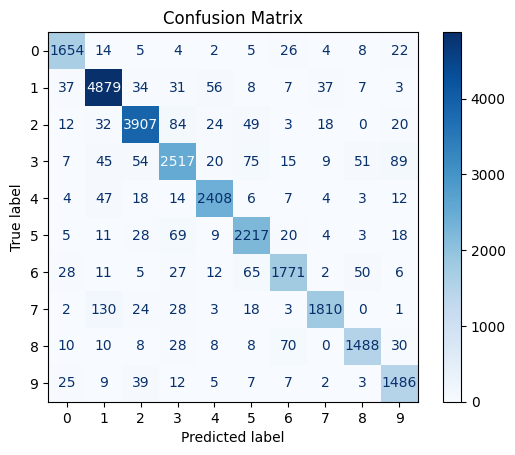

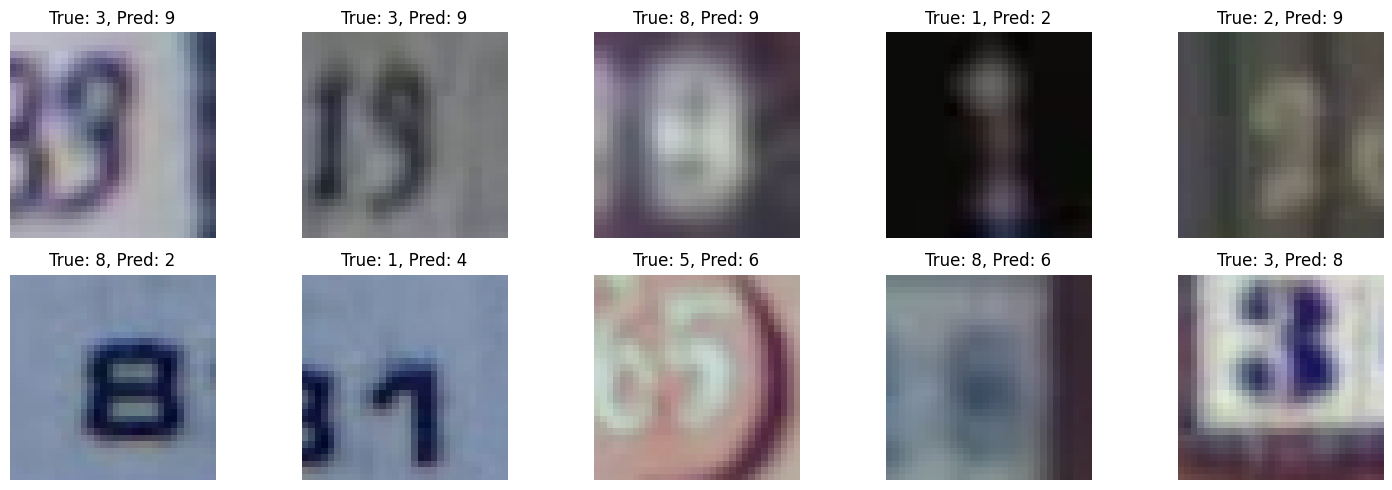

In [14]:
preds, labels, (incorrect_samples, incorrect_true_labels, incorrect_pred_labels) = evaluate_model(model, testloader)
plot_confusion_matrix(labels, preds)
visualize_incorrect_samples(incorrect_samples, true_labels=incorrect_true_labels, pred_labels=incorrect_pred_labels)

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(labels, preds):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


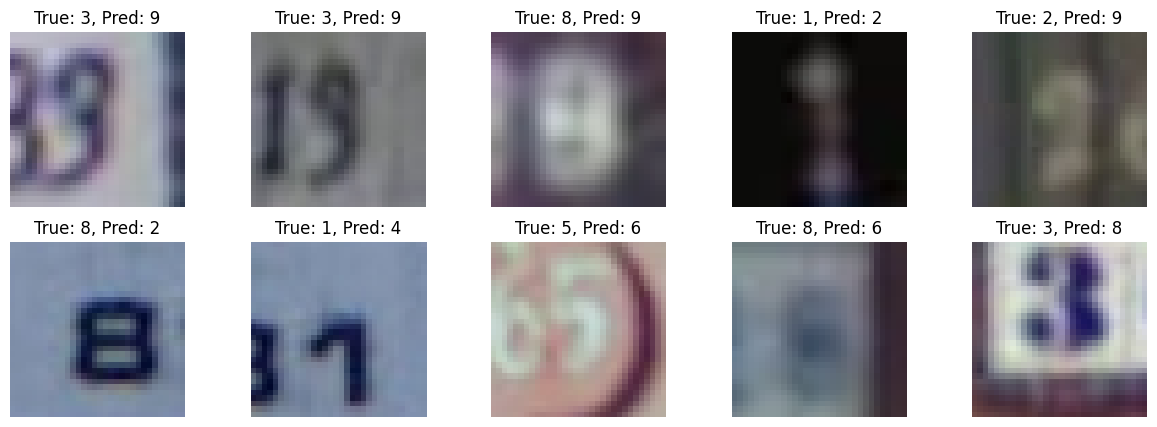

In [17]:
import torch
import matplotlib.pyplot as plt

def display_incorrect_predictions(model, testloader, device):
    model.eval()
    incorrect_images = []
    incorrect_true_labels = []
    incorrect_pred_labels = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Collect incorrect predictions
            # Hint: Create a boolean mask to find where the predictions do not match the true labels.
            mismatches = (preds != labels)

            # Hint: Use the 'mismatches' mask to select the inputs that were incorrectly classified.
            incorrect_images.extend(inputs[mismatches])
            incorrect_true_labels.extend(labels[mismatches].cpu().numpy())
            incorrect_pred_labels.extend(preds[mismatches].cpu().numpy())

    # Display a subset of incorrect predictions
    num_to_display = 10  # Adjust based on preference
    plt.figure(figsize=(15, 5))
    for i in range(min(len(incorrect_images), num_to_display)):

        # Hint: Rearrange the tensor dimensions from (C, H, W) to (H, W, C) for matplotlib.
        img = incorrect_images[i].permute(1, 2, 0).cpu().numpy()

        # Hint: Reverse the normalization (mean=0.5, std=0.5) to restore the original image colors.
        img = img * 0.5 + 0.5
        img = np.clip(img, 0, 1) # Ensure values are valid for plotting

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"True: {incorrect_true_labels[i]}, Pred: {incorrect_pred_labels[i]}")
        plt.axis('off')
    plt.show()

# Call the function
display_incorrect_predictions(model, testloader, device)

## Part 2 – Performing Adversarial Attacks on Our Model

We will implement the Fast Gradient Sign Method (FGSM) and create a function `eval_adversarial(model, test_loader, epsilon)` that applies FGSM to the test dataset. The function produces perturbed versions of the original images and computes the model's accuracy only on those perturbed samples. After performing the attack with $\varepsilon=0.1$, the test accuracy is expected to drop below 25%.


### Visualization

In [22]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define FGSM Attack
def fgsm_attack(model, data, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_data = data + epsilon * sign_data_grad
    perturbed_data = torch.clamp(perturbed_data, -1.0, 1.0)
    return perturbed_data

def unnormalize(img):
    """
    Reverse the normalization applied to an image tensor.

    Args:
        img (torch.Tensor): Normalized image tensor (C, H, W).

    Returns:
        torch.Tensor: Unnormalized image tensor (C, H, W) with values in [0, 1].
    """
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1).to(img.device)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1).to(img.device)

    # Unnormalize the image
    img = img * std + mean
    return img.clamp(0, 1)  # Ensure values are within [0, 1]

def eval_adversarial(model, test_loader, epsilon, device='cuda'):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    wrong_after_attack = []
    right_before_attack = []
    original_images = []
    perturbed_images = []

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Enable gradient calculation on the image tensor itself.
        images.requires_grad = True

        # Perform a forward pass on the original, clean images.
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Check which predictions were correct before the attack.
        correct_before = (predicted == labels)

        # Store all labels for the confusion matrix
        all_labels.extend(labels.cpu().numpy())
        
        # Calculate the loss to be used for generating the gradient.
        loss = F.cross_entropy(outputs, labels)

        # Zero out all existing gradients.
        model.zero_grad()

        # Perform backpropagation to calculate gradients of the loss with respect to the images.
        loss.backward()

        # Extract the gradient data from the image tensor.
        data_grad = images.grad.data

        # Generate the perturbed image using the provided attack function.
        perturbed_data = fgsm_attack(model, images, epsilon, data_grad)

        # Get the model's predictions on the new, perturbed images.
        outputs = model(perturbed_data)
        _, perturbed_predicted = torch.max(outputs.data, 1)

        # Store predictions for the confusion matrix
        all_predictions.extend(perturbed_predicted.cpu().numpy())
        
        # Update the total count of correct predictions on the adversarial examples.
        correct += (perturbed_predicted == labels).sum().item()
        total += labels.size(0)
        
        # Identify samples that were correct before the attack but are now incorrect.
        right_before = correct_before & (perturbed_predicted != labels)

        if len(original_images) < 10:  # Limit the number of stored samples
            # Using the 'right_before' mask, store the original images that were successfully attacked.
            original_images.extend(images[right_before])
            # Store the corresponding perturbed images.
            perturbed_images.extend(perturbed_data[right_before])

    accuracy = 100 * correct / total
    return accuracy, all_predictions, all_labels, original_images, perturbed_images

# Plot confusion matrix
def plot_confusion_matrix(predictions, labels):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix After FGSM Attack')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def visualize_perturbed_images(original_images, perturbed_images, epsilon):
    """
    Visualize original and perturbed images that were right before but wrong after the attack.

    Args:
        original_images (list): List of original image tensors.
        perturbed_images (list): List of perturbed image tensors.
        epsilon (float): The FGSM attack epsilon value.
    """
    n = min(5, len(original_images))
    plt.figure(figsize=(15, 6))

    for i in range(n):
        # Unnormalize original and perturbed images
        original = unnormalize(original_images[i])
        perturbed = unnormalize(perturbed_images[i])

        # Original image
        plt.subplot(2, n, i + 1)
        plt.imshow(original.permute(1, 2, 0).cpu().detach().numpy())
        plt.title("Original")
        plt.axis('off')

        # Perturbed image
        plt.subplot(2, n, i + n + 1)
        plt.imshow(original.permute(1, 2, 0).cpu().detach().numpy())
        plt.title(f"Perturbed (ε={epsilon})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()




def evaluate_multiple_epsilons(model, test_loader, epsilons, device='cuda'):
    accuracies = []

    for eps in epsilons:
        accuracy, predictions, labels, original_images, perturbed_images = eval_adversarial(
            model, test_loader, eps, device
        )
        accuracies.append(accuracy)

        print(f"Epsilon: {eps}, Accuracy: {accuracy:.2f}%")
        plot_confusion_matrix(predictions, labels)
        visualize_perturbed_images(original_images, perturbed_images, eps)

    # Plot accuracy vs. epsilon
    plt.figure(figsize=(10, 6))
    plt.plot(epsilons, accuracies, marker='o', label="Accuracy")
    plt.title("Model Accuracy vs. Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.legend()
    plt.show()

    return accuracies



Epsilon: 0.01, Accuracy: 69.94%


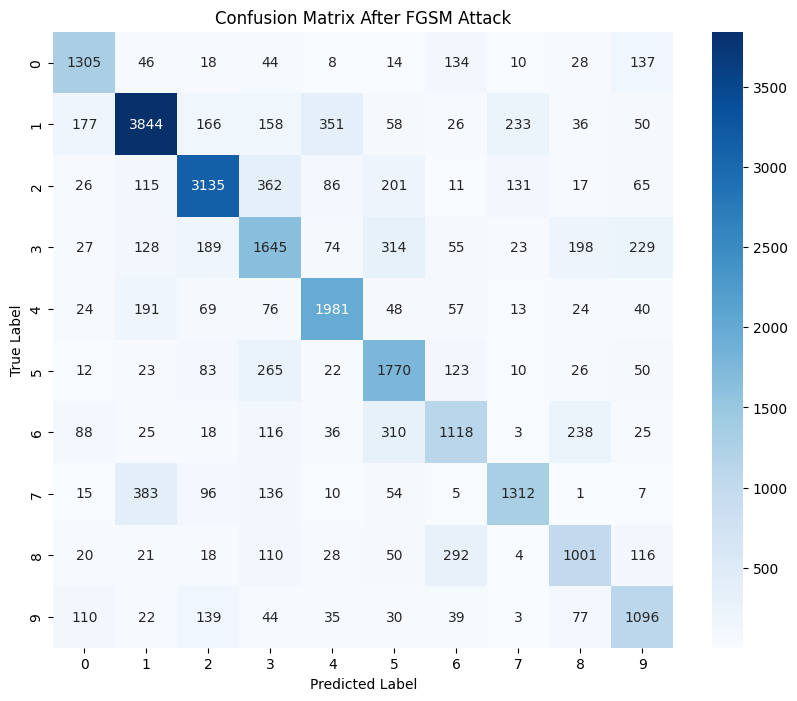

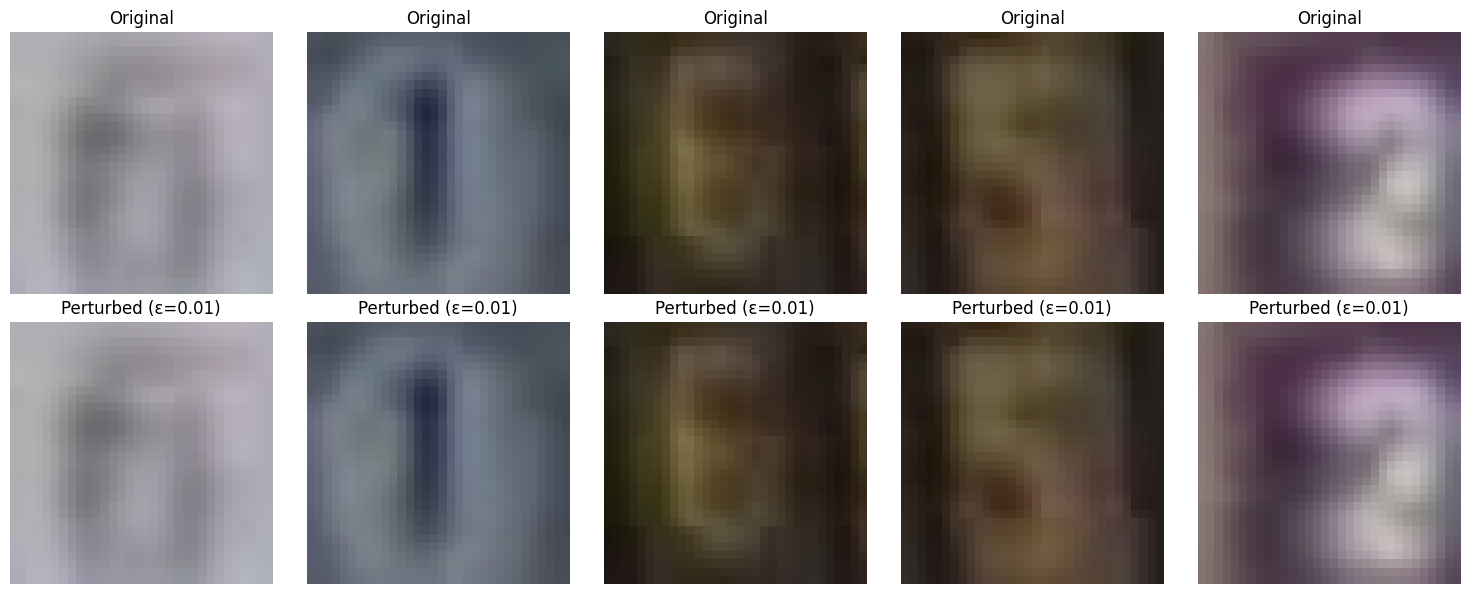

Epsilon: 0.05, Accuracy: 15.27%


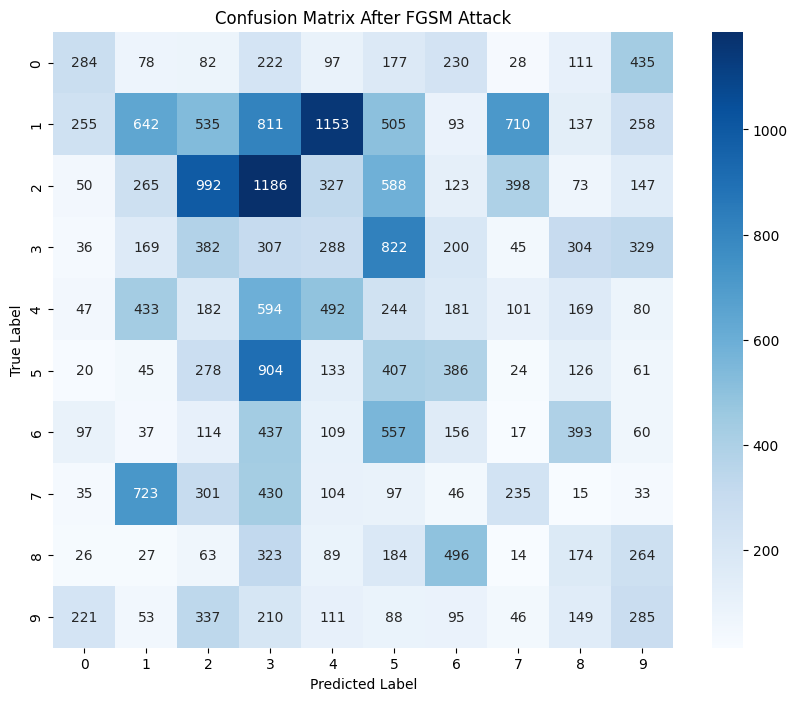

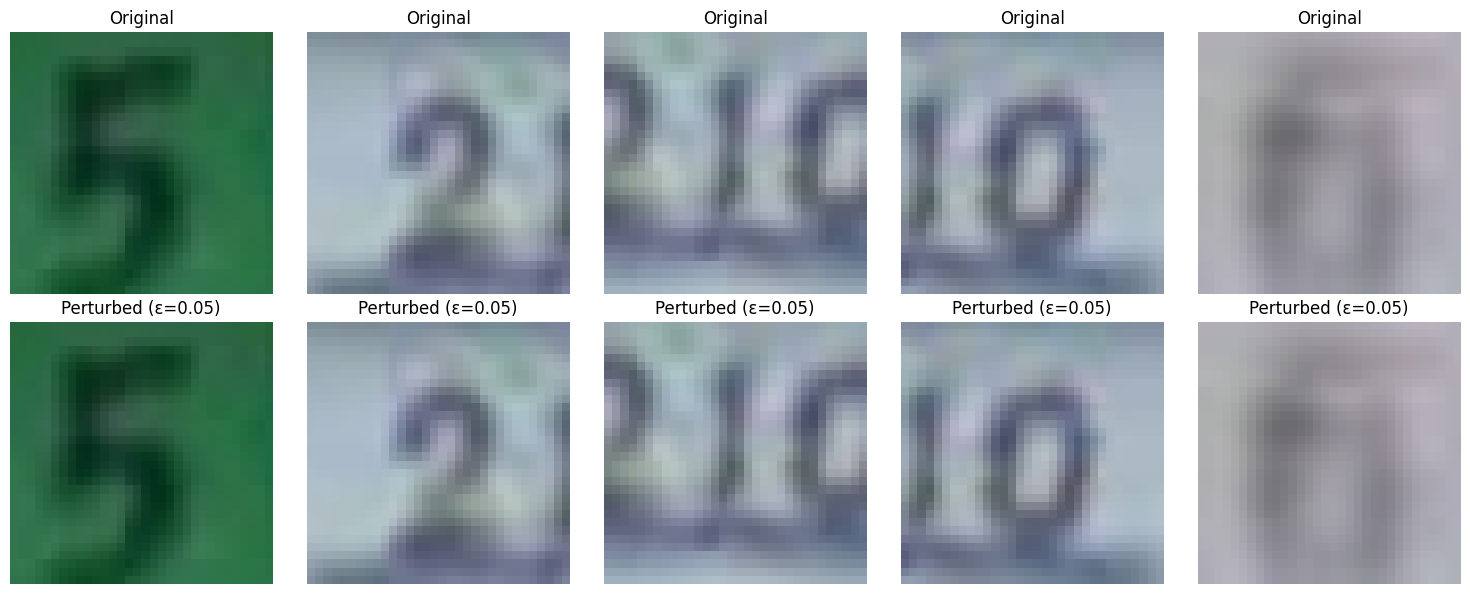

Epsilon: 0.1, Accuracy: 3.62%


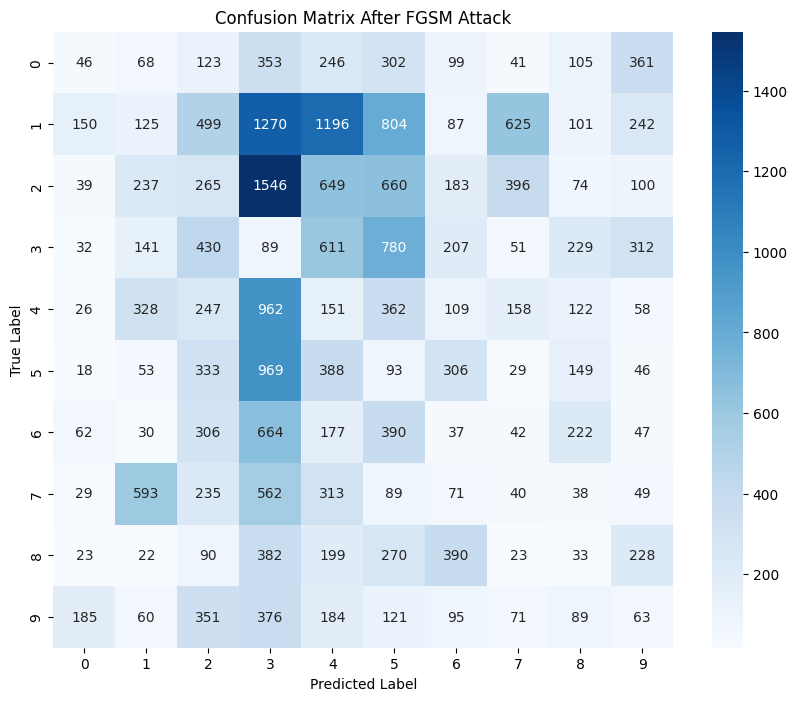

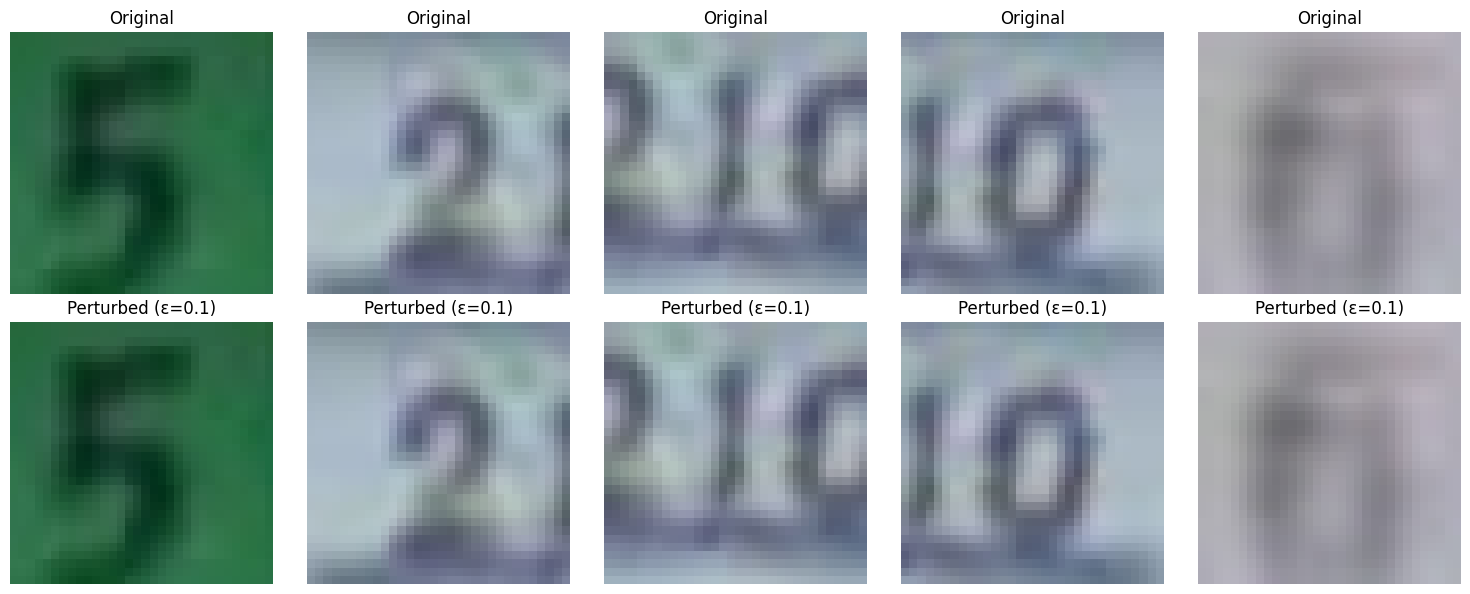

Epsilon: 0.2, Accuracy: 2.68%


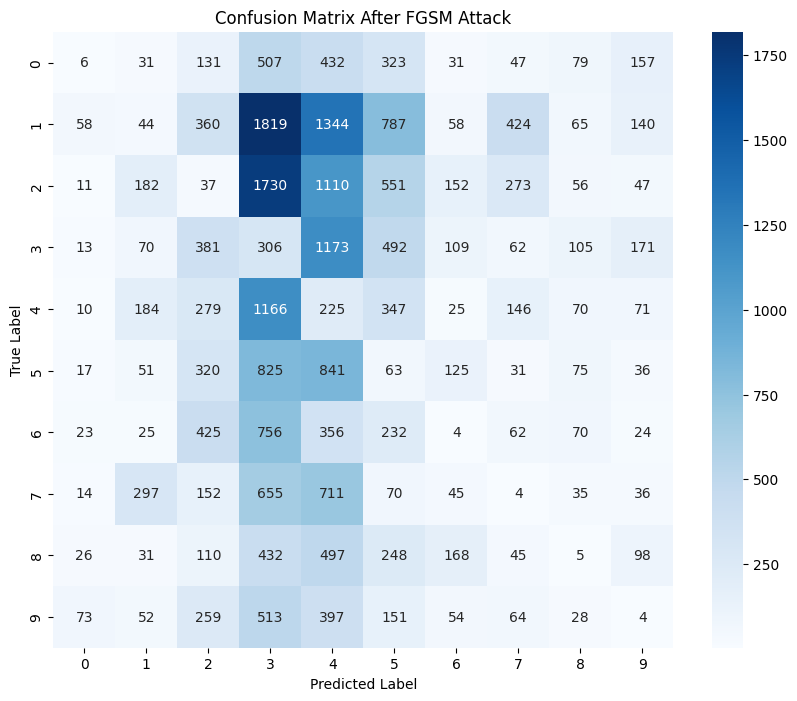

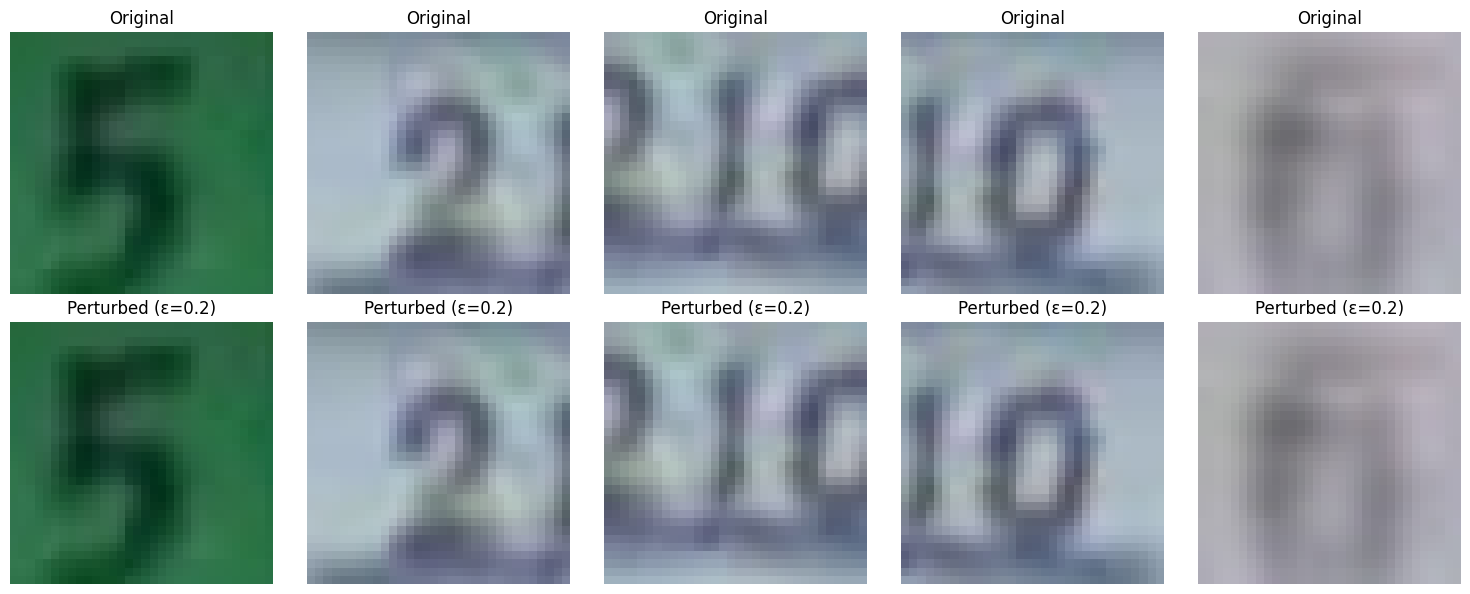

Epsilon: 0.3, Accuracy: 4.47%


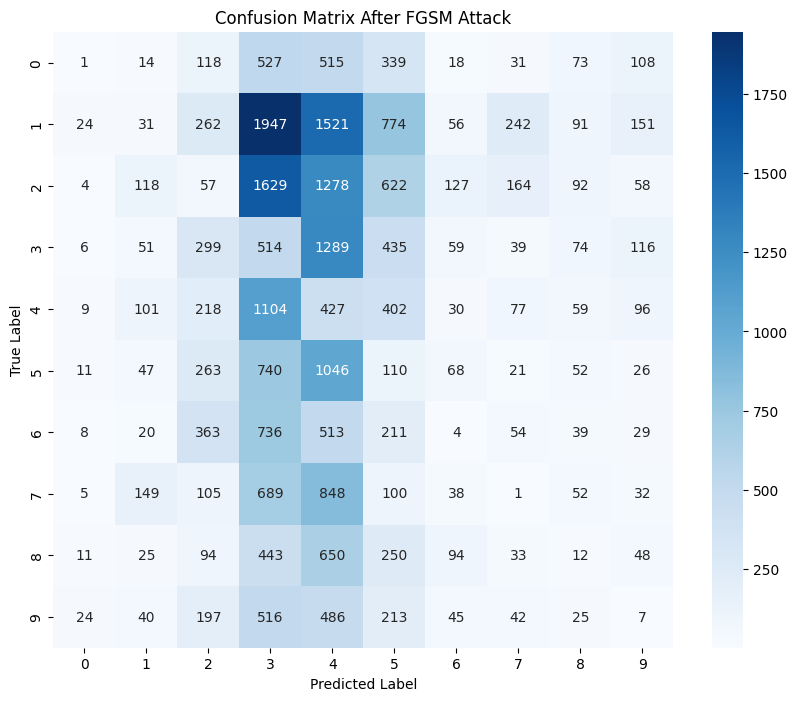

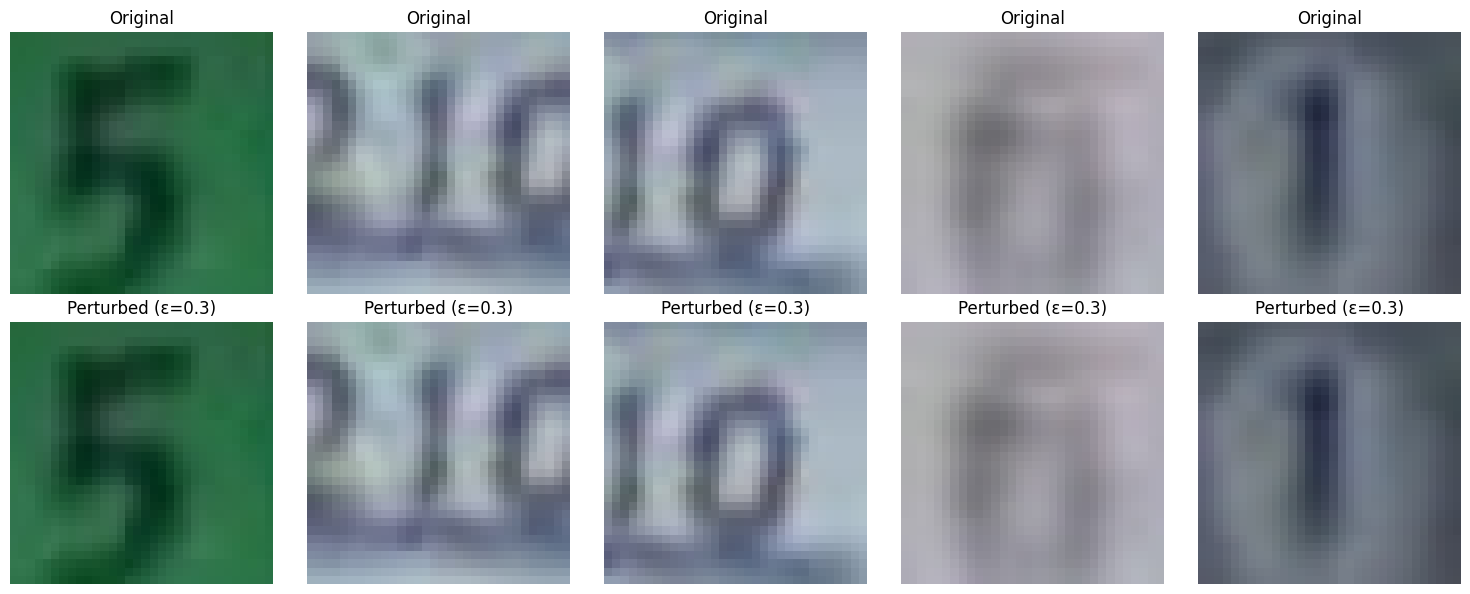

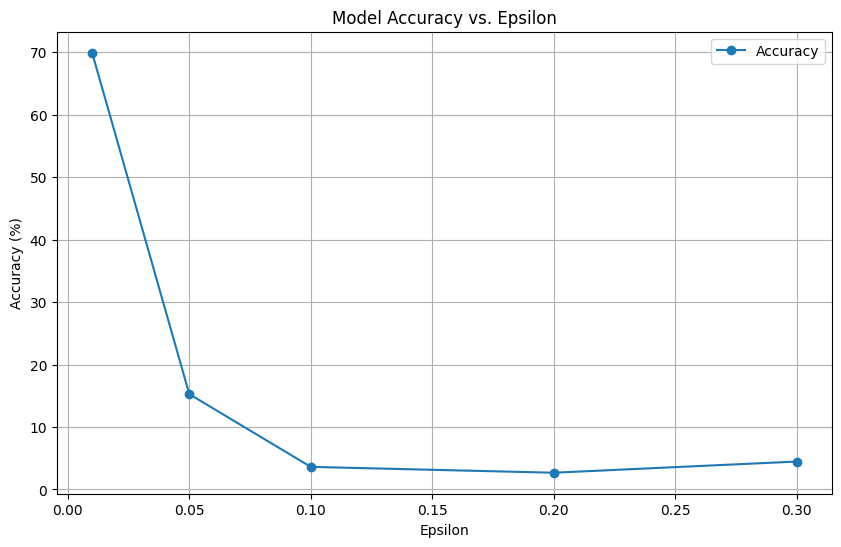

In [23]:
epsilons = [0.01, 0.05, 0.1, 0.2, 0.3]
accuracies = evaluate_multiple_epsilons(model, testloader, epsilons, device='cuda')

## Part 3 – Training our model using adversarial training

### Visualization

We will visualize the confusion matrix alongside several examples of images that the model misclassified. Afterwards, we will discuss how the model’s performance has changed compared to its previous state.

In [24]:
import torch.nn.functional as F

def generate_adversarial_examples(model, inputs, labels, epsilon, device='cuda'):
    """
    Generate adversarial examples for training using FGSM.
    """
    # Allow gradients to be computed with respect to the input images.
    inputs.requires_grad = True

    # Get the model's initial predictions on the clean inputs.
    outputs = model(inputs)

    # Calculate the loss which will be used to generate the adversarial perturbation.
    loss = F.cross_entropy(outputs, labels)

    # Clear any previous gradients.
    model.zero_grad()

    # Compute the gradients of the loss with respect to the input images.
    loss.backward()

    # Extract the gradient data from the input tensor.
    data_grad = inputs.grad.data

    # Use the sign of the gradient to create the perturbed image (FGSM attack).
    perturbed_data = inputs + epsilon * data_grad.sign()
    # Clamp the data to the valid normalized range [-1, 1]
    perturbed_data = torch.clamp(perturbed_data, -1.0, 1.0)

    return perturbed_data

In [25]:
import torch

def train_with_adversarial_training(model, train_loader, optimizer, criterion, epsilon, device='cuda', num_epochs=10):
    """
    Train the model using adversarial training.

    Args:
        model: The neural network model.
        train_loader: DataLoader for the training dataset.
        optimizer: Optimizer for training.
        criterion: Loss function.
        epsilon: Strength of FGSM attack for adversarial training.
        device: Device to train on (default: 'cuda').
        num_epochs: Number of training epochs.
    """
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Generate adversarial examples for the current batch.
            adv_images = generate_adversarial_examples(model, images, labels, epsilon, device).detach()

            # Combine the original and adversarial images into a single batch tensor.
            combined_images = combined_images = torch.cat([images, adv_images], dim=0)

            # Create the corresponding label tensor for the combined batch.
            combined_labels = torch.cat([labels, labels], dim=0)

            # Perform the forward pass on the combined images.
            outputs = model(combined_images)

            # Calculate the loss using the combined images and labels.
            loss = criterion(outputs, combined_labels)

            # Zero the gradients.
            optimizer.zero_grad()

            # Perform the backward pass.
            loss.backward()

            # Update the model's weights.
            optimizer.step()

            # Update statistics
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += combined_labels.size(0)

            # Update the total number of correct predictions for the epoch.
            correct += (predicted == combined_labels).sum().item()

        # Print epoch statistics
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")

In [26]:
def evaluate_robustness(model, test_loader, epsilon, device='cuda'):
    """
    Assesses how well the model performs when tested on adversarial examples.
    """
    accuracy, predictions, labels, _, _ = eval_adversarial(model, test_loader, epsilon, device)
    print(f"Model robustness for epsilon={epsilon}: Accuracy = {accuracy:.2f}%")
    return accuracy


In [27]:
model = ImprovedCNN().to('cuda')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

epsilon = 0.1
train_with_adversarial_training(model, trainloader, optimizer, criterion, epsilon, device='cuda', num_epochs=20)

Epoch [1/20], Loss: 1252.3727, Accuracy: 20.92%
Epoch [2/20], Loss: 1041.4698, Accuracy: 35.18%
Epoch [3/20], Loss: 841.1382, Accuracy: 48.85%
Epoch [4/20], Loss: 738.2123, Accuracy: 55.87%
Epoch [5/20], Loss: 649.3152, Accuracy: 61.76%
Epoch [6/20], Loss: 593.0117, Accuracy: 65.49%
Epoch [7/20], Loss: 555.7550, Accuracy: 67.65%
Epoch [8/20], Loss: 514.1150, Accuracy: 70.08%
Epoch [9/20], Loss: 442.9684, Accuracy: 74.40%
Epoch [10/20], Loss: 390.6560, Accuracy: 77.75%
Epoch [11/20], Loss: 333.3748, Accuracy: 81.42%
Epoch [12/20], Loss: 291.0228, Accuracy: 83.84%
Epoch [13/20], Loss: 258.2789, Accuracy: 85.85%
Epoch [14/20], Loss: 242.1534, Accuracy: 86.76%
Epoch [15/20], Loss: 234.1858, Accuracy: 87.22%
Epoch [16/20], Loss: 221.1906, Accuracy: 87.95%
Epoch [17/20], Loss: 210.5896, Accuracy: 88.60%
Epoch [18/20], Loss: 205.6998, Accuracy: 88.92%
Epoch [19/20], Loss: 198.4614, Accuracy: 89.32%
Epoch [20/20], Loss: 194.0680, Accuracy: 89.48%


In [28]:
test_epsilons = [ 0.1]
for eps in test_epsilons:
    evaluate_robustness(model, testloader, eps, device='cuda')

Model robustness for epsilon=0.1: Accuracy = 96.23%


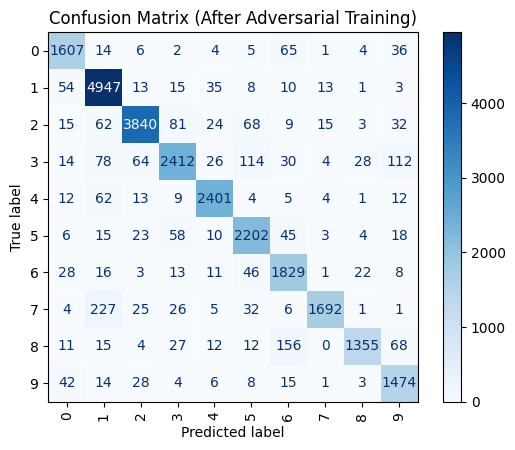

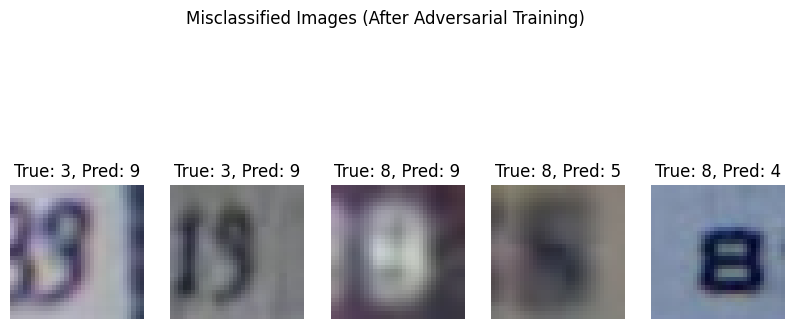

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataloader, device='cuda'):
    """
    Plot the confusion matrix for the given model.
    """
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Get the predicted labels from the model's outputs.
            _, predicted = torch.max(outputs.data, 1)

            # Store the ground truth labels for the batch.
            true_labels.extend(labels.cpu().numpy())

            # Store the predicted labels for the batch.
            pred_labels.extend(predicted.cpu().numpy())

    # Compute the confusion matrix using the collected true and predicted labels.
    cm = confusion_matrix(true_labels, pred_labels)

    # Create a display object for the confusion matrix.
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))

    # Plot the confusion matrix.
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix (After Adversarial Training)")
    plt.show()

def plot_misclassified_images(model, dataloader, device='cuda', num_images=5):
    """
    Plot examples of misclassified images with true and predicted labels.
    """
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # Identify misclassified images.
            for img, true_label, pred_label in zip(images, labels, predicted):
                # Check if the prediction is incorrect and if we have not yet collected enough images.
                if pred_label != true_label and len(misclassified) < num_images:
                    # If incorrect, append the image, true label, and predicted label to the list.
                    misclassified.append((img.cpu(), true_label.cpu(), pred_label.cpu()))

    # Plot misclassified images.
    plt.figure(figsize=(10, 5))
    for i, (img, true_label, pred_label) in enumerate(misclassified):
        img = img.numpy()

        # Normalize the image to the [0, 1] range for proper display.
        img = img * 0.5 + 0.5
        img = np.clip(img, 0, 1) # Ensure values are in [0, 1]

        plt.subplot(1, num_images, i + 1)

        # Display the image, transposing its dimensions from (C, H, W) to (H, W, C).
        plt.imshow(np.transpose(img, (1, 2, 0)))

        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis('off')
    plt.suptitle("Misclassified Images (After Adversarial Training)")
    plt.show()

# Visualize Confusion Matrix
plot_confusion_matrix(model, testloader, device='cuda')

# Visualize Misclassified Images
plot_misclassified_images(model, testloader, device='cuda', num_images=5)
